# <center> Bank Marketing </center>


## Introduction

*problem description*
    

<div style="text-align: justify"> The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The goal of the bank telemarketing campaign is to sell long-term deposits. Within a campaign, the human agents execute phone calls to a list of clients to sell the deposit (outbound) or, if meanwhile, the client calls the contact center for any other reason, he is asked to subscribe to the deposit (inbound). Thus, the result is a binary unsuccessful or successful contact.
</div>

*task description*

<div style="text-align: justify"> In this project, the classification task is considered.The classification goal is to predict whether the client will subscribe to a term deposit (variable y).</div>

*features explanation*


* **bank client data:**
   * age (numeric)
   * job : type of job 
   (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   * marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   * education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   * default: has credit in default? (categorical: "no","yes","unknown")
   * housing: has housing loan? (categorical: "no","yes","unknown")
   * loan: has personal loan? (categorical: "no","yes","unknown")
* **related with the last contact of the current campaign:**
   * contact: contact communication type (categorical: "cellular","telephone") 
   * month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   * day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
   * duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target    (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* **other attributes:**
  * campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  * pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  * previous: number of contacts performed before this campaign and for this client (numeric)
  * poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
* **social and economic context attributes:**
  * emp.var.rate: employment variation rate - quarterly indicator (numeric)
  * cons.price.idx: consumer price index - monthly indicator (numeric)     
  * cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  * euribor3m: euribor 3 month rate - daily indicator (numeric)
  * nr.employed: number of employees - quarterly indicator (numeric)

* **Output variable (desired target):
  * y - has the client subscribed a term deposit? (binary: "yes","no")</div>

*dataset description*

In [ ]:
install.packages('dplyr')
install.packages('caret')
install.packages("ROCR")
install.packages("ROSE")
install.packages("rpart")
install.packages("caTools")
install.packages('fpc')
install.packages('e1071', dependencies=TRUE)
install.packages("purrr")
install.packages('kernlab')
library(ROCR)
library(ROSE)
library(rpart)
library(caTools)
library(dplyr)
library(caret)
library(corrplot)
library(ggplot2)
library(purrr)
library(cluster)
library(fpc)
library(kernlab)

In [59]:
#import the data
train_data=read.table("bank-additional-full.csv",header=TRUE,sep=";")
valid_data = read.table("bank-additional.csv",header=TRUE,sep=";")

In [60]:
dim(train_data)
dim(valid_data)

[1] 41188    21

[1] 4119   21

In [61]:
# changing the unknown values in data to the NA
train_data[train_data == 'unknown' ] <-NA

In [62]:
valid_data[valid_data == 'unknown' ] <-NA

In [63]:
sum(is.na(valid_data))

[1] 1230

In [64]:
# removing NA from data
valid_data = na.omit(valid_data)

In [65]:
sum(is.na(train_data))

[1] 12718

In [66]:
train_data = na.omit(train_data)

In [67]:
dim(train_data)

[1] 30488    21

In [68]:
# deleate redundant predictor
train_data <- subset(train_data, select = -c(duration))
valid_data <- subset(valid_data, select = -c(duration))

In [69]:
str(valid_data)

'data.frame':	3090 obs. of  20 variables:
 $ age           : int  30 39 25 47 32 32 31 36 36 47 ...
 $ job           : Factor w/ 12 levels "admin.","blue-collar",..: 2 8 8 1 8 1 8 7 1 2 ...
 $ marital       : Factor w/ 4 levels "divorced","married",..: 2 3 2 2 3 3 1 3 2 2 ...
 $ education     : Factor w/ 8 levels "basic.4y","basic.6y",..: 3 4 4 7 7 7 6 1 4 1 ...
 $ default       : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ housing       : Factor w/ 3 levels "no","unknown",..: 3 1 3 3 1 3 1 1 1 3 ...
 $ loan          : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ contact       : Factor w/ 2 levels "cellular","telephone": 1 2 2 1 1 1 1 1 2 2 ...
 $ month         : Factor w/ 10 levels "apr","aug","dec",..: 7 7 5 8 10 10 8 4 7 5 ...
 $ day_of_week   : Factor w/ 5 levels "fri","mon","thu",..: 1 1 5 2 3 2 4 3 5 3 ...
 $ campaign      : int  2 4 1 1 3 4 1 1 2 2 ...
 $ pdays         : int  999 999 999 999 999 999 999 999 999 999 ...
 $ previous      : 

In [70]:
#label encoding
train_data$default <- ifelse(train_data$default == "yes",1,0)
train_data$housing <- ifelse(train_data$housing == "yes",1,0)
train_data$loan <- ifelse(train_data$loan == "yes",1,0)
train_data$contact <- ifelse(train_data$contact == "cellular",1,0)
train_data$y <- ifelse(train_data$y == "yes",1,0)

In [71]:
valid_data$default <- ifelse(valid_data$default == "yes",1,0)
valid_data$housing <- ifelse(valid_data$housing == "yes",1,0)
valid_data$loan <- ifelse(valid_data$loan == "yes",1,0)
valid_data$contact <- ifelse(valid_data$contact == "cellular",1,0)
valid_data$y <- ifelse(valid_data$y == "yes",1,0)

In [72]:
# function to perform an ordinal encoding
encode_ordinal <- function(x, order = unique(x)) {
  x <- as.numeric(factor(x, levels = order, exclude = NULL))
  x
}

In [73]:
# education can be encoded according to the study degree
train_data$education <- encode_ordinal(train_data$education, order = c("illiterate","basic.4y", "basic.6y", "basic.9y", "high.school","professional.course","university.degree"))

In [74]:
str(train_data)

'data.frame':	30488 obs. of  20 variables:
 $ age           : int  56 37 40 56 59 24 25 25 29 57 ...
 $ job           : Factor w/ 12 levels "admin.","blue-collar",..: 4 8 1 8 1 10 8 8 2 4 ...
 $ marital       : Factor w/ 4 levels "divorced","married",..: 2 2 2 2 2 3 3 3 3 1 ...
 $ education     : num  2 5 3 5 6 6 5 5 5 2 ...
 $ default       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ housing       : num  0 1 0 0 0 1 1 1 0 1 ...
 $ loan          : num  0 0 0 1 0 0 0 0 1 0 ...
 $ contact       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ month         : Factor w/ 10 levels "apr","aug","dec",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ day_of_week   : Factor w/ 5 levels "fri","mon","thu",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ campaign      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pdays         : int  999 999 999 999 999 999 999 999 999 999 ...
 $ previous      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ poutcome      : Factor w/ 3 levels "failure","nonexistent",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ emp.var.rate  : num  1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.

In [75]:
#creates a full set of dummy variables
dmy <- dummyVars(~ ., data = train_data, fullRank = T)
train_data <- data.frame(predict(dmy, newdata = train_data))

In [76]:
str(train_data)

'data.frame':	30488 obs. of  44 variables:
 $ age                 : num  56 37 40 56 59 24 25 25 29 57 ...
 $ job.blue.collar     : num  0 0 0 0 0 0 0 0 1 0 ...
 $ job.entrepreneur    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ job.housemaid       : num  1 0 0 0 0 0 0 0 0 1 ...
 $ job.management      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ job.retired         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ job.self.employed   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ job.services        : num  0 1 0 1 0 0 1 1 0 0 ...
 $ job.student         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ job.technician      : num  0 0 0 0 0 1 0 0 0 0 ...
 $ job.unemployed      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ job.unknown         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ marital.married     : num  1 1 1 1 1 0 0 0 0 0 ...
 $ marital.single      : num  0 0 0 0 0 1 1 1 1 0 ...
 $ marital.unknown     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ education           : num  2 5 3 5 6 6 5 5 5 2 ...
 $ default             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ housing             : num 

In [77]:
#function turn all variables, which have less than 7 unique value into factor
col_names <- sapply(train_data, function(col) length(unique(col)) <= 7)
train_data[ , col_names] <- lapply(train_data[ , col_names] , factor)


In [78]:
train_data$previous<-as.numeric(train_data$previous)

In [79]:
train_data<-select(train_data,-marital.unknown,-job.unknown)

In [80]:
valid_data$education <- encode_ordinal(valid_data$education, order = c("illiterate","basic.4y", "basic.6y", "basic.9y", "high.school","professional.course","university.degree"))

In [81]:
dmy <- dummyVars(" ~ .", data = valid_data, fullRank = T)
valid_data <- data.frame(predict(dmy, newdata = valid_data))

In [82]:
col_name <- sapply(valid_data, function(col) length(unique(col)) <= 7)
valid_data[ , col_name] <- lapply(valid_data[ , col_name] , factor)

valid_data<-select(valid_data,-marital.unknown,-job.unknown)

In [83]:

valid_data$previous<-as.numeric(valid_data$previous)

In [84]:
valid_data$education<-as.factor(valid_data$education)

# <center> EDA </center>

In [28]:
OptimizeMfrow = function(elements) {
  columns = ceiling(sqrt(elements))
  rows = ifelse(columns * (columns - 1) < elements, columns, columns - 1)
  return(c(rows, columns))
}

In [29]:
DoHistogram = function(values, values.name) {
  histogram = hist(values, plot = FALSE)
  density.estimate = density(values)
  y.maximum = max(histogram$density, density.estimate$y)
  plot(histogram, freq = FALSE, ylim = c(0, y.maximum), 
       xlab = values.name, ylab = "density", main = NULL)
  lines(density.estimate, lwd = 2)
}

In [30]:
DoScatterplot = function(x.values, x.name) {
  plot(x.values, df_train$y,
       xlab = x.name, ylab = "Y", main = NULL, col = gray(0.4))
}

In [31]:
DoBoxplot = function(values, values.name) {
  boxplot(values, horizontal = FALSE, xlab = values.name)
  median.leg = paste("median = ", round(median(values), digits = 4),"\n")
  q25 = quantile(values, 0.25)
  q25.leg = paste("25th percentile =", round(q25,digits = 4),"\n")
  q75 = quantile(values, 0.75)
  q75.leg = paste("75th percentile =", round(q75,digits = 4))
  legend(x = "bottomleft", paste(q25.leg, median.leg, q75.leg, sep = ""), bty = "n",cex=1.3)
}

In [32]:
num_cols <- unlist(lapply(train_data, is.numeric))

In [33]:
print(summary(train_data))
cormat = cor(train_data[,num_cols])
print(cormat, digits = 1)

      age        job.blue.collar job.entrepreneur job.housemaid job.management
 Min.   :17.00   0:24813         0:29399          0:29798       0:28177       
 1st Qu.:31.00   1: 5675         1: 1089          1:  690       1: 2311       
 Median :37.00                                                                
 Mean   :39.03                                                                
 3rd Qu.:45.00                                                                
 Max.   :95.00                                                                
                                                                              
 job.retired job.self.employed job.services job.student job.technician
 0:29272     0:29396           0:27631      0:29878     0:25015       
 1: 1216     1: 1092           1: 2857      1:  610     1: 5473       
                                                                      
                                                                      
             

In [34]:
cor.mtest = function(mat, ...) {
  mat = as.matrix(mat)
  n = ncol(mat)
  p.mat= matrix(NA, n, n)
  diag(p.mat) = 0
  for (i in 1:(n - 1)) {
    for (j in (i + 1):n) {
      tmp = cor.test(mat[, i], mat[, j], ...)
      p.mat[i, j] = p.mat[j, i] = tmp$p.value
    }
  }
  colnames(p.mat) = rownames(p.mat) = colnames(mat)
  p.mat
}

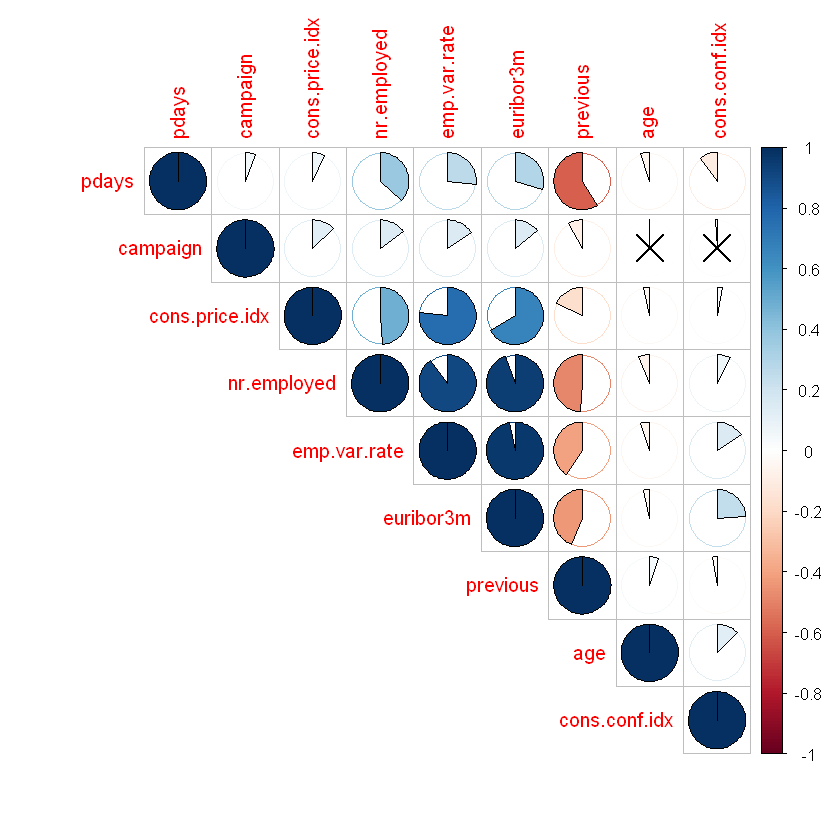

In [36]:
p.mat = cor.mtest(train_data[,num_cols])
corrplot(cormat, type="upper", method="pie",order="hclust", p.mat = p.mat, sig.level = 0.01)

### <center>From the above graph we can conclude, that the more circle-filled, the bigger correlation has pair of variables. The color defines the direction of correlation(blue - positive, red - negative)</center>

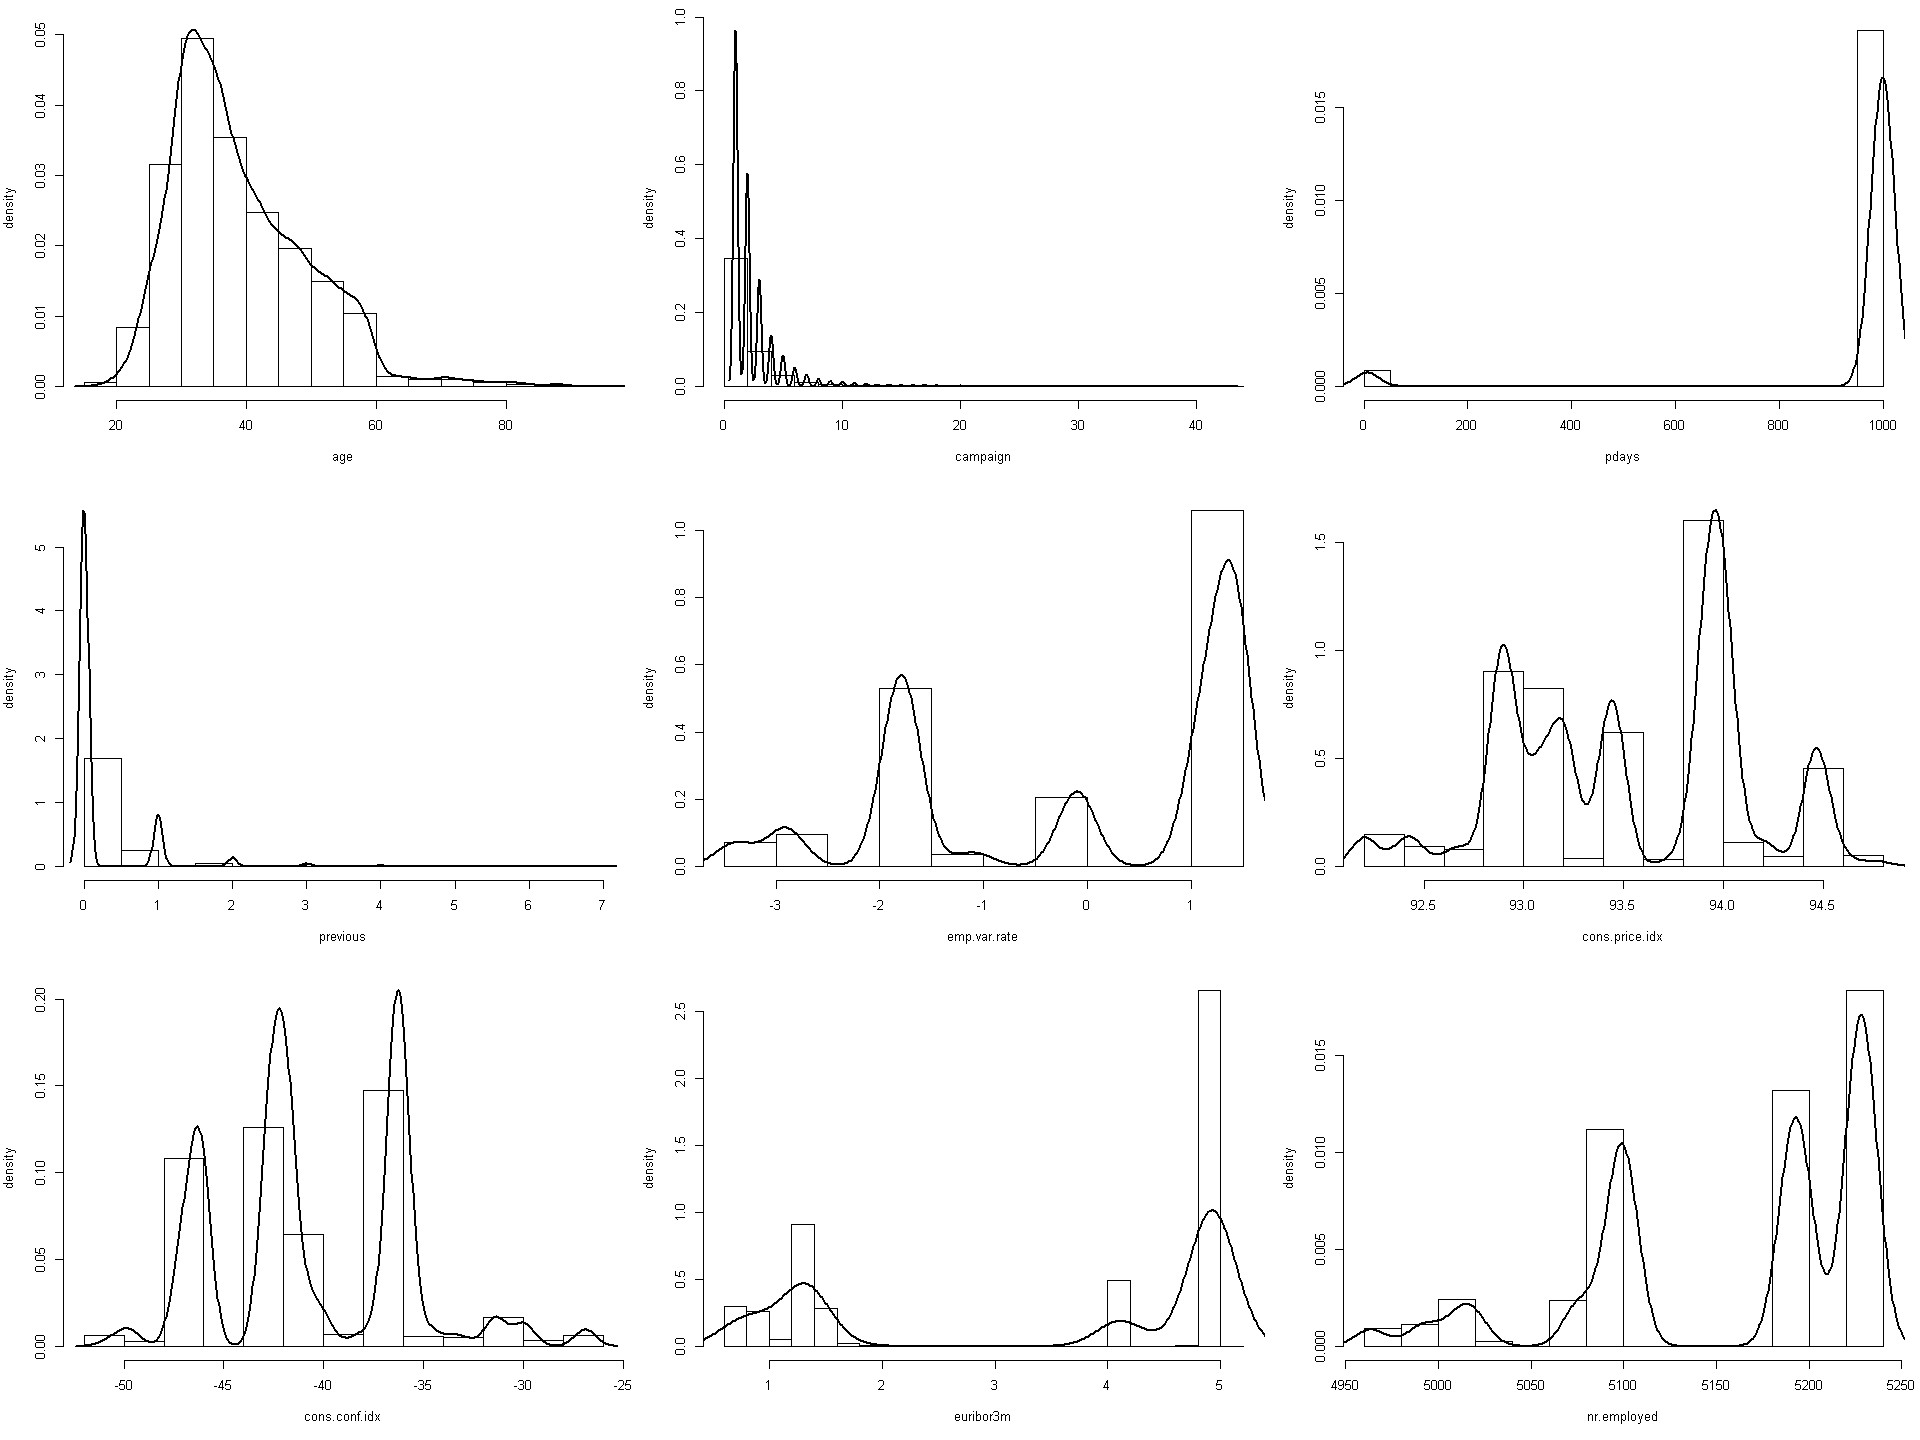

In [37]:
options(repr.plot.width=16, repr.plot.height=12)
par(mfrow = OptimizeMfrow(ncol(train_data[,num_cols])),  mar = c(5, 4, 1, 1))
invisible(mapply(DoHistogram, train_data[,num_cols], names(train_data[,num_cols])))

### <center>The majority of numerical variables have a very big value variety. So the scaling is required.</center>

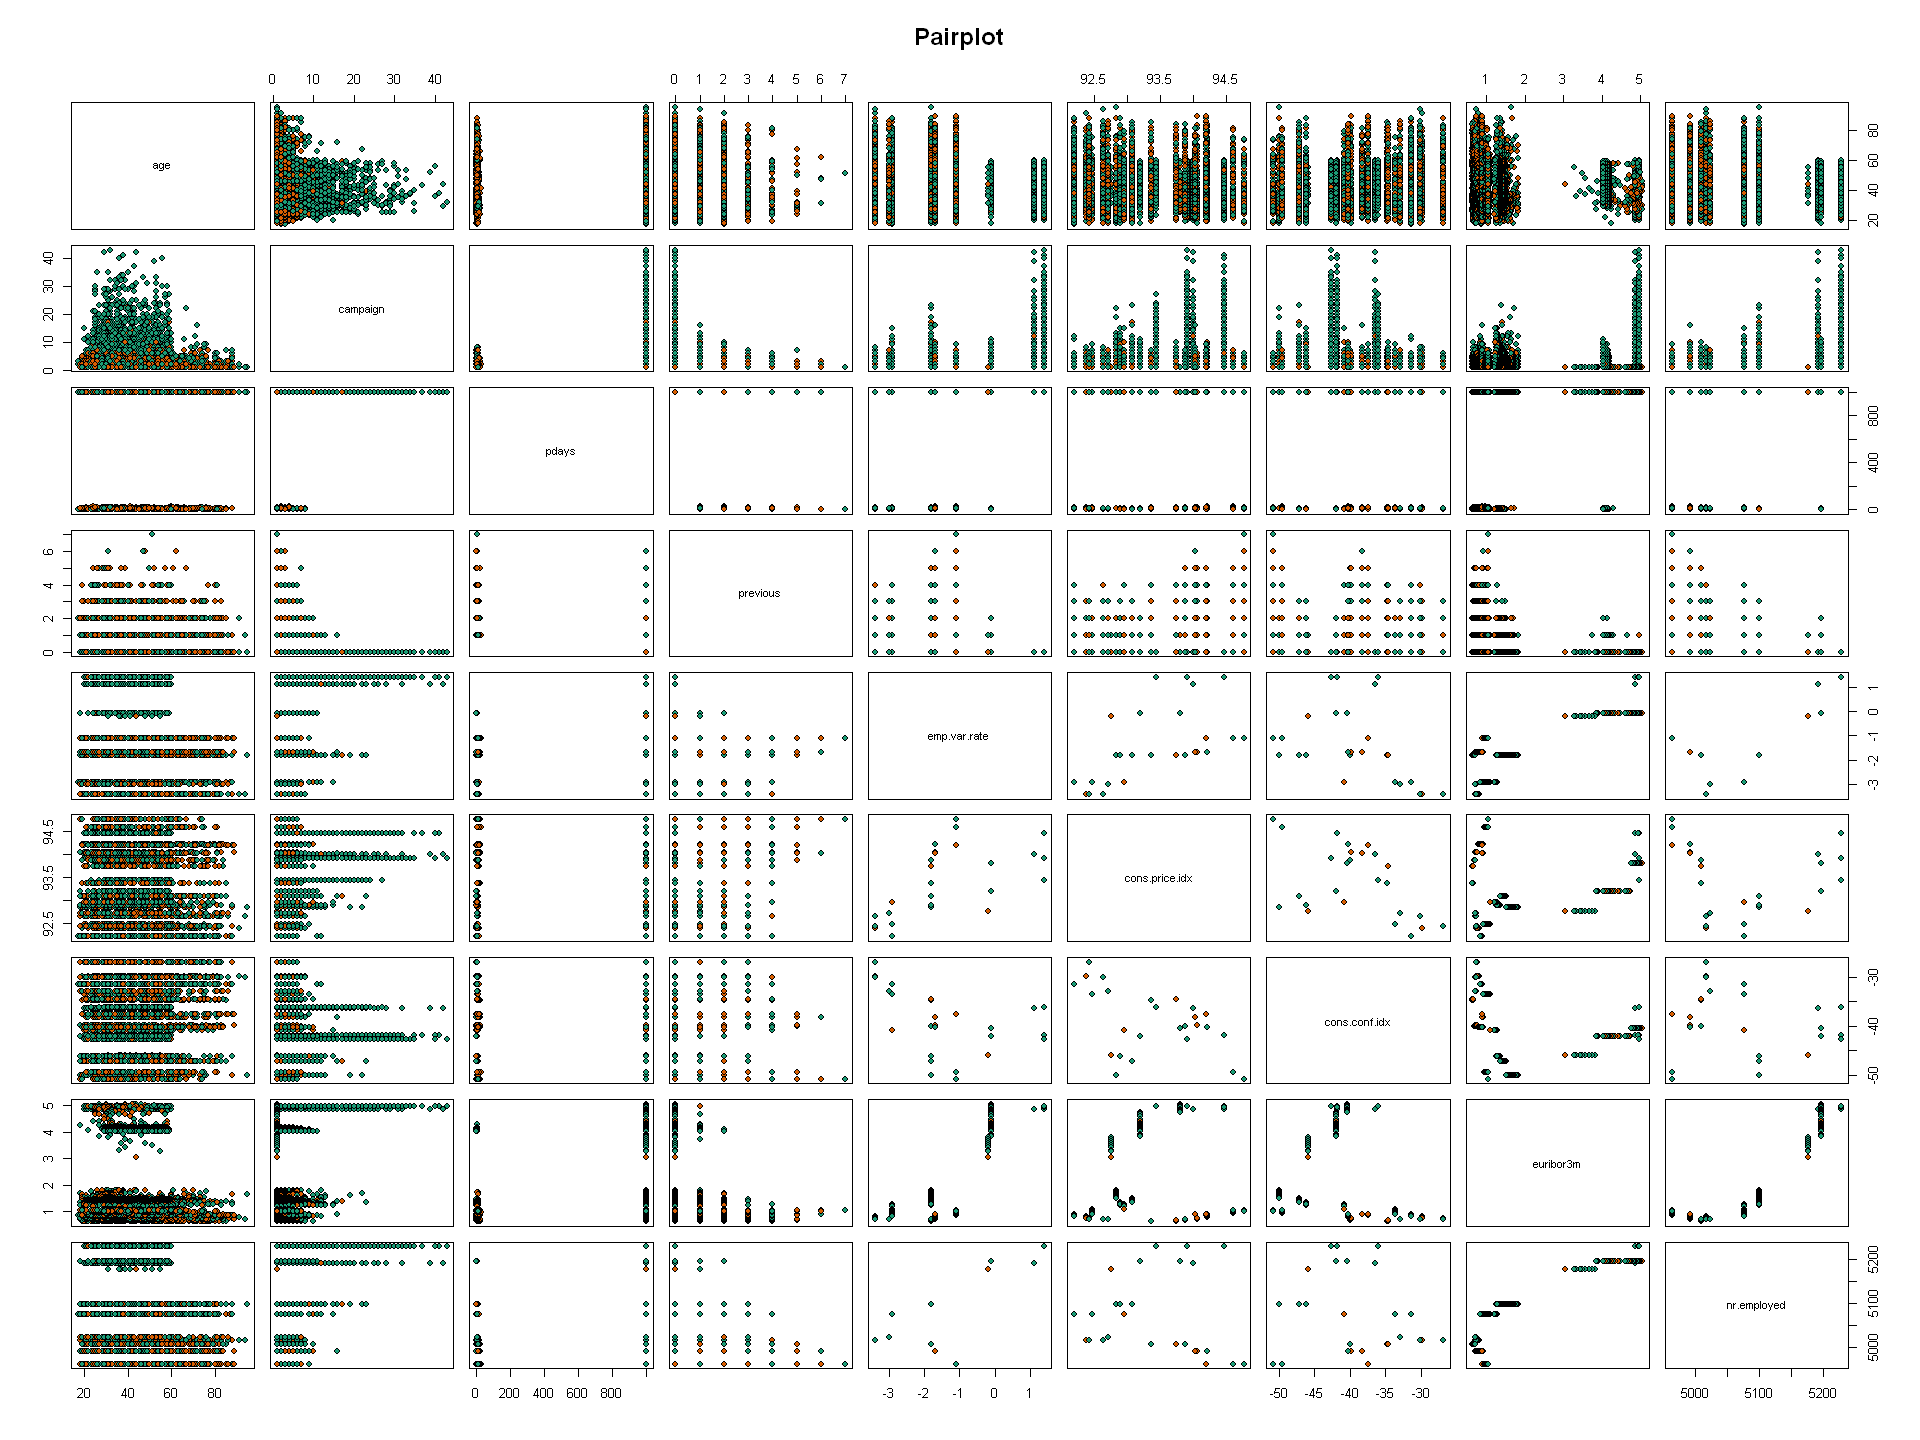

In [38]:
pairs(train_data[,num_cols], 
      main = "Pairplot",
      pch = 21, 
      bg = c("#1b9e77", "#d95f02")[unclass(train_data$y)])

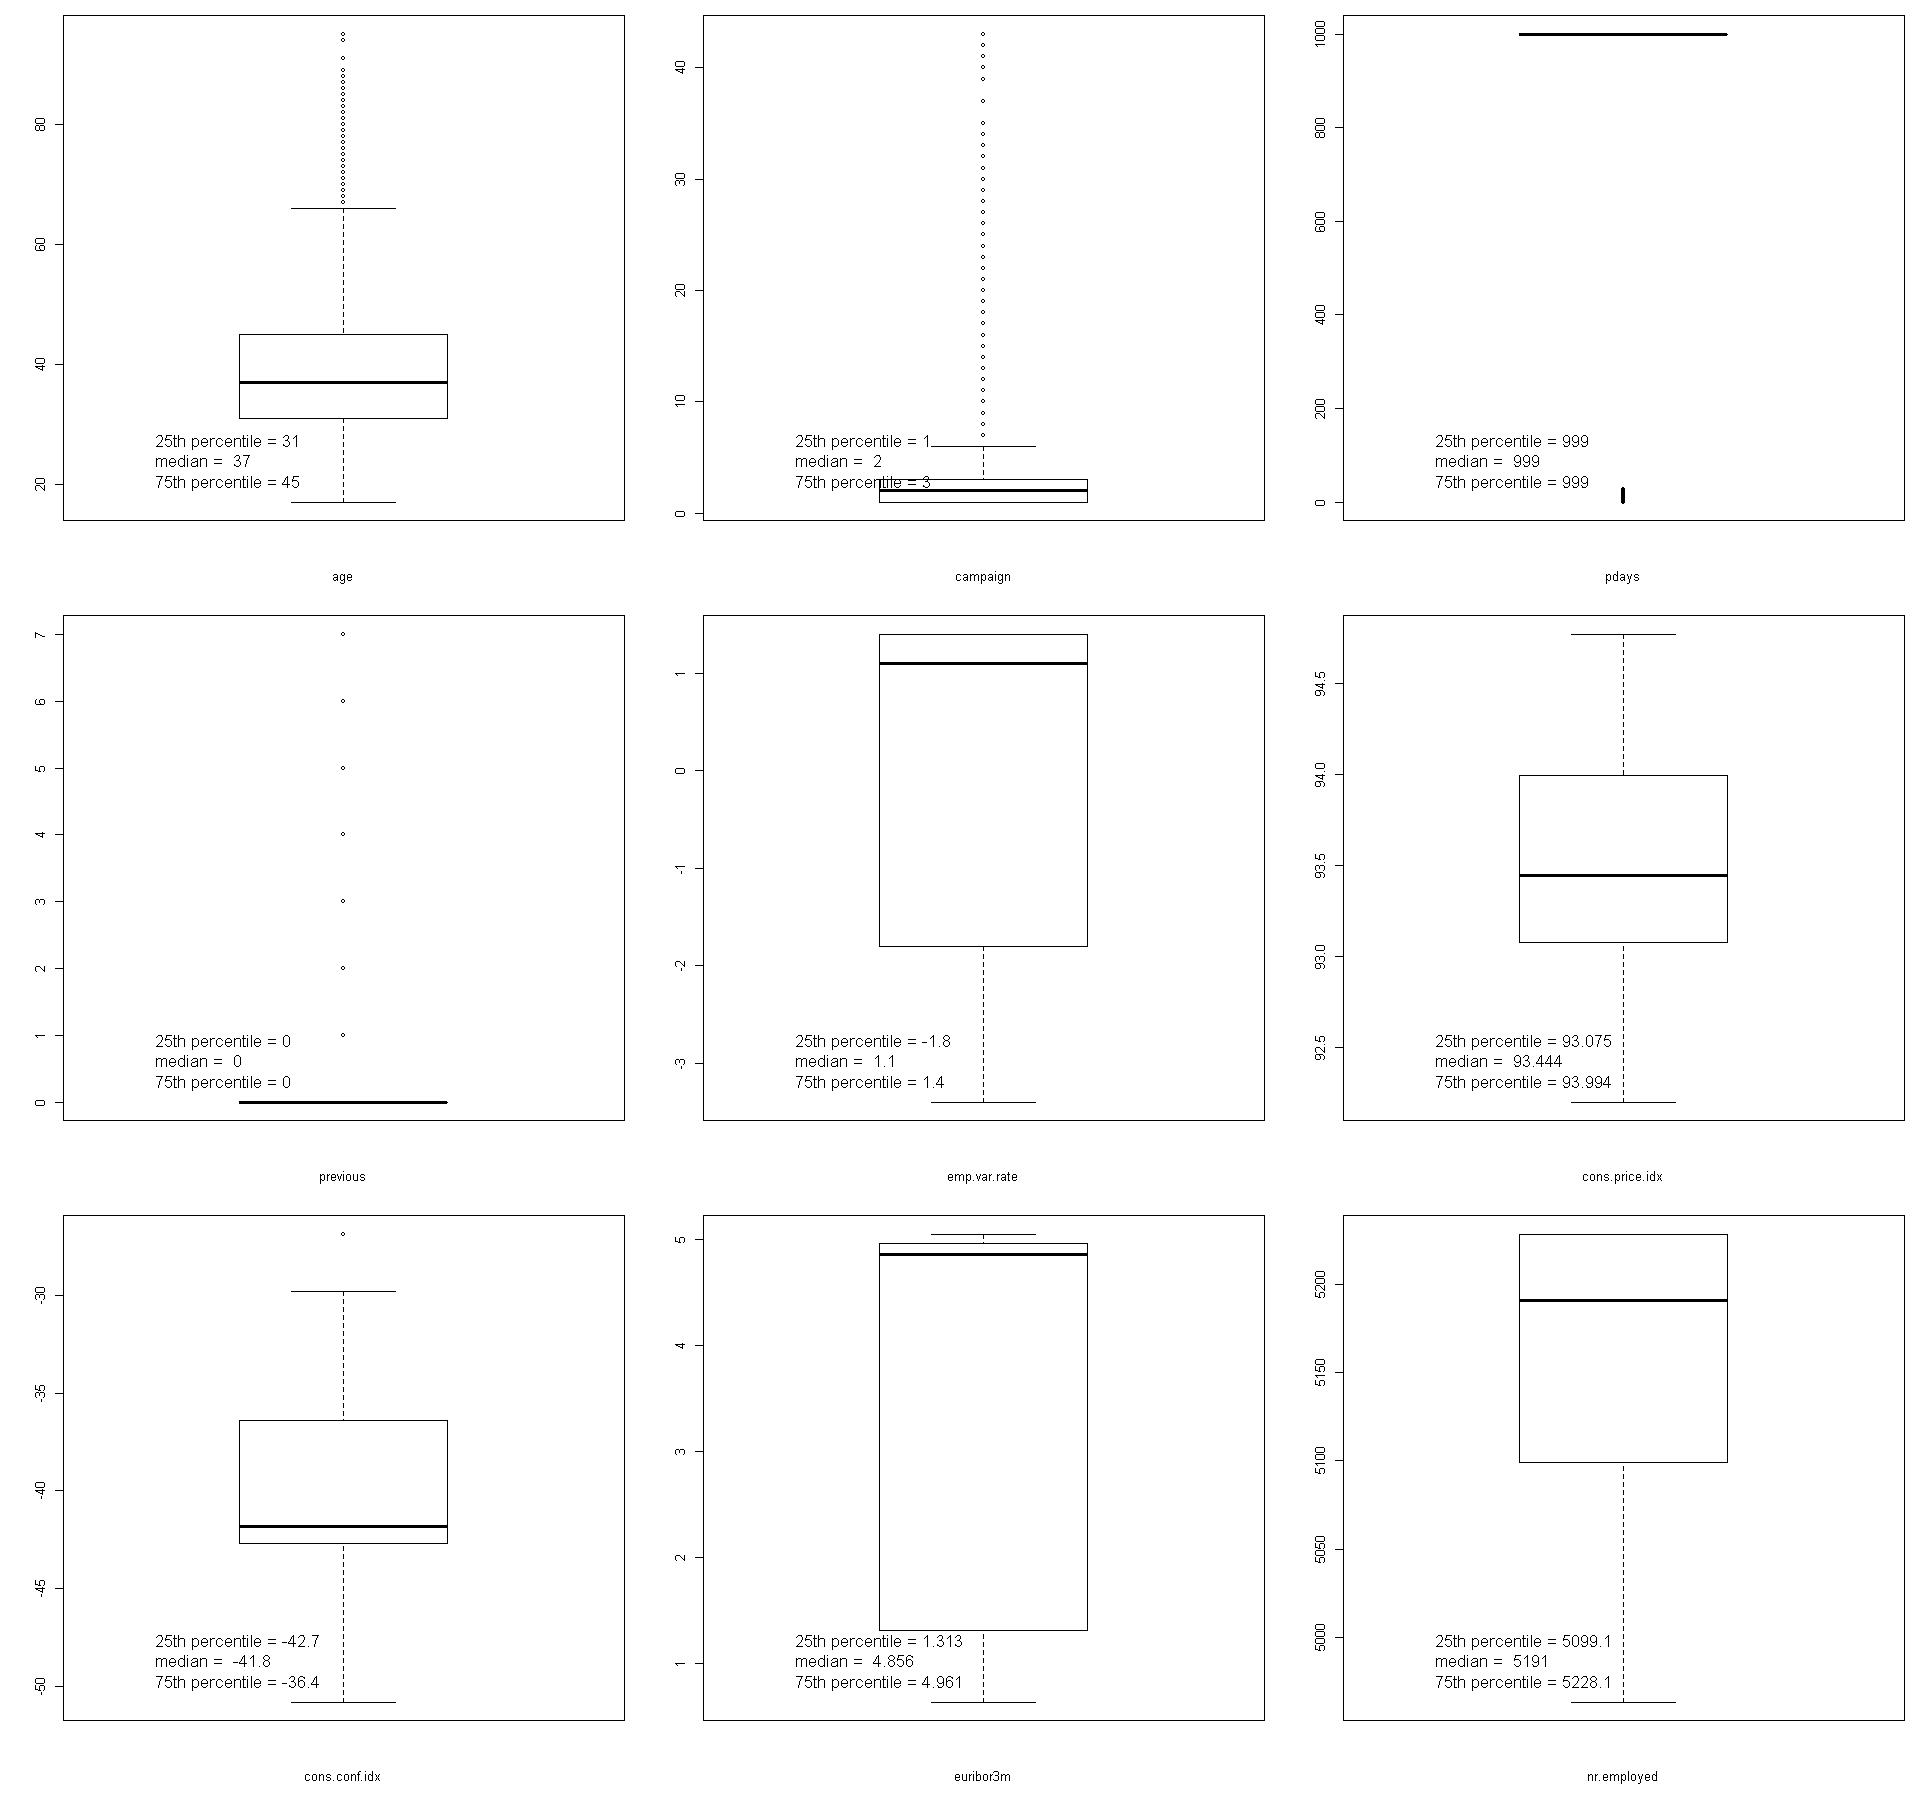

In [39]:
options(repr.plot.width=16, repr.plot.height=15)
par(mfrow = OptimizeMfrow(ncol(train_data[,num_cols])),  mar = c(5, 4, 1, 1))
invisible(mapply(DoBoxplot, train_data[,num_cols], names(train_data[,num_cols])))

# Outliers

There is no need to remove outliers. Regardless of the fact, that we see a small number of outliers in boxplots, they are all explainable and make real-life sense. 

# <center> PCA </center>

In [137]:
pca_train <- subset(train_data, select = -c(y))

In [138]:
prin_comp <- prcomp(pca_train, scale. = T)

In [157]:
# The first four PCA components
prin_comp$rotation[1:5,1:4]

,PC1,PC2,PC3,PC4
age,-0.034362464,-0.41702297,0.01984054,-0.214217093
job.blue.collar,0.038263172,-0.16312238,-0.25559988,0.215662670
job.entrepreneur,0.013331546,-0.03696050,-0.01995528,-0.006754400
job.housemaid,0.011505267,-0.09694904,0.01182847,-0.008430708
job.management,-0.005348203,-0.02191049,0.03639115,-0.107602530


In [203]:
dim(prin_comp$x)

[1] 21341    41

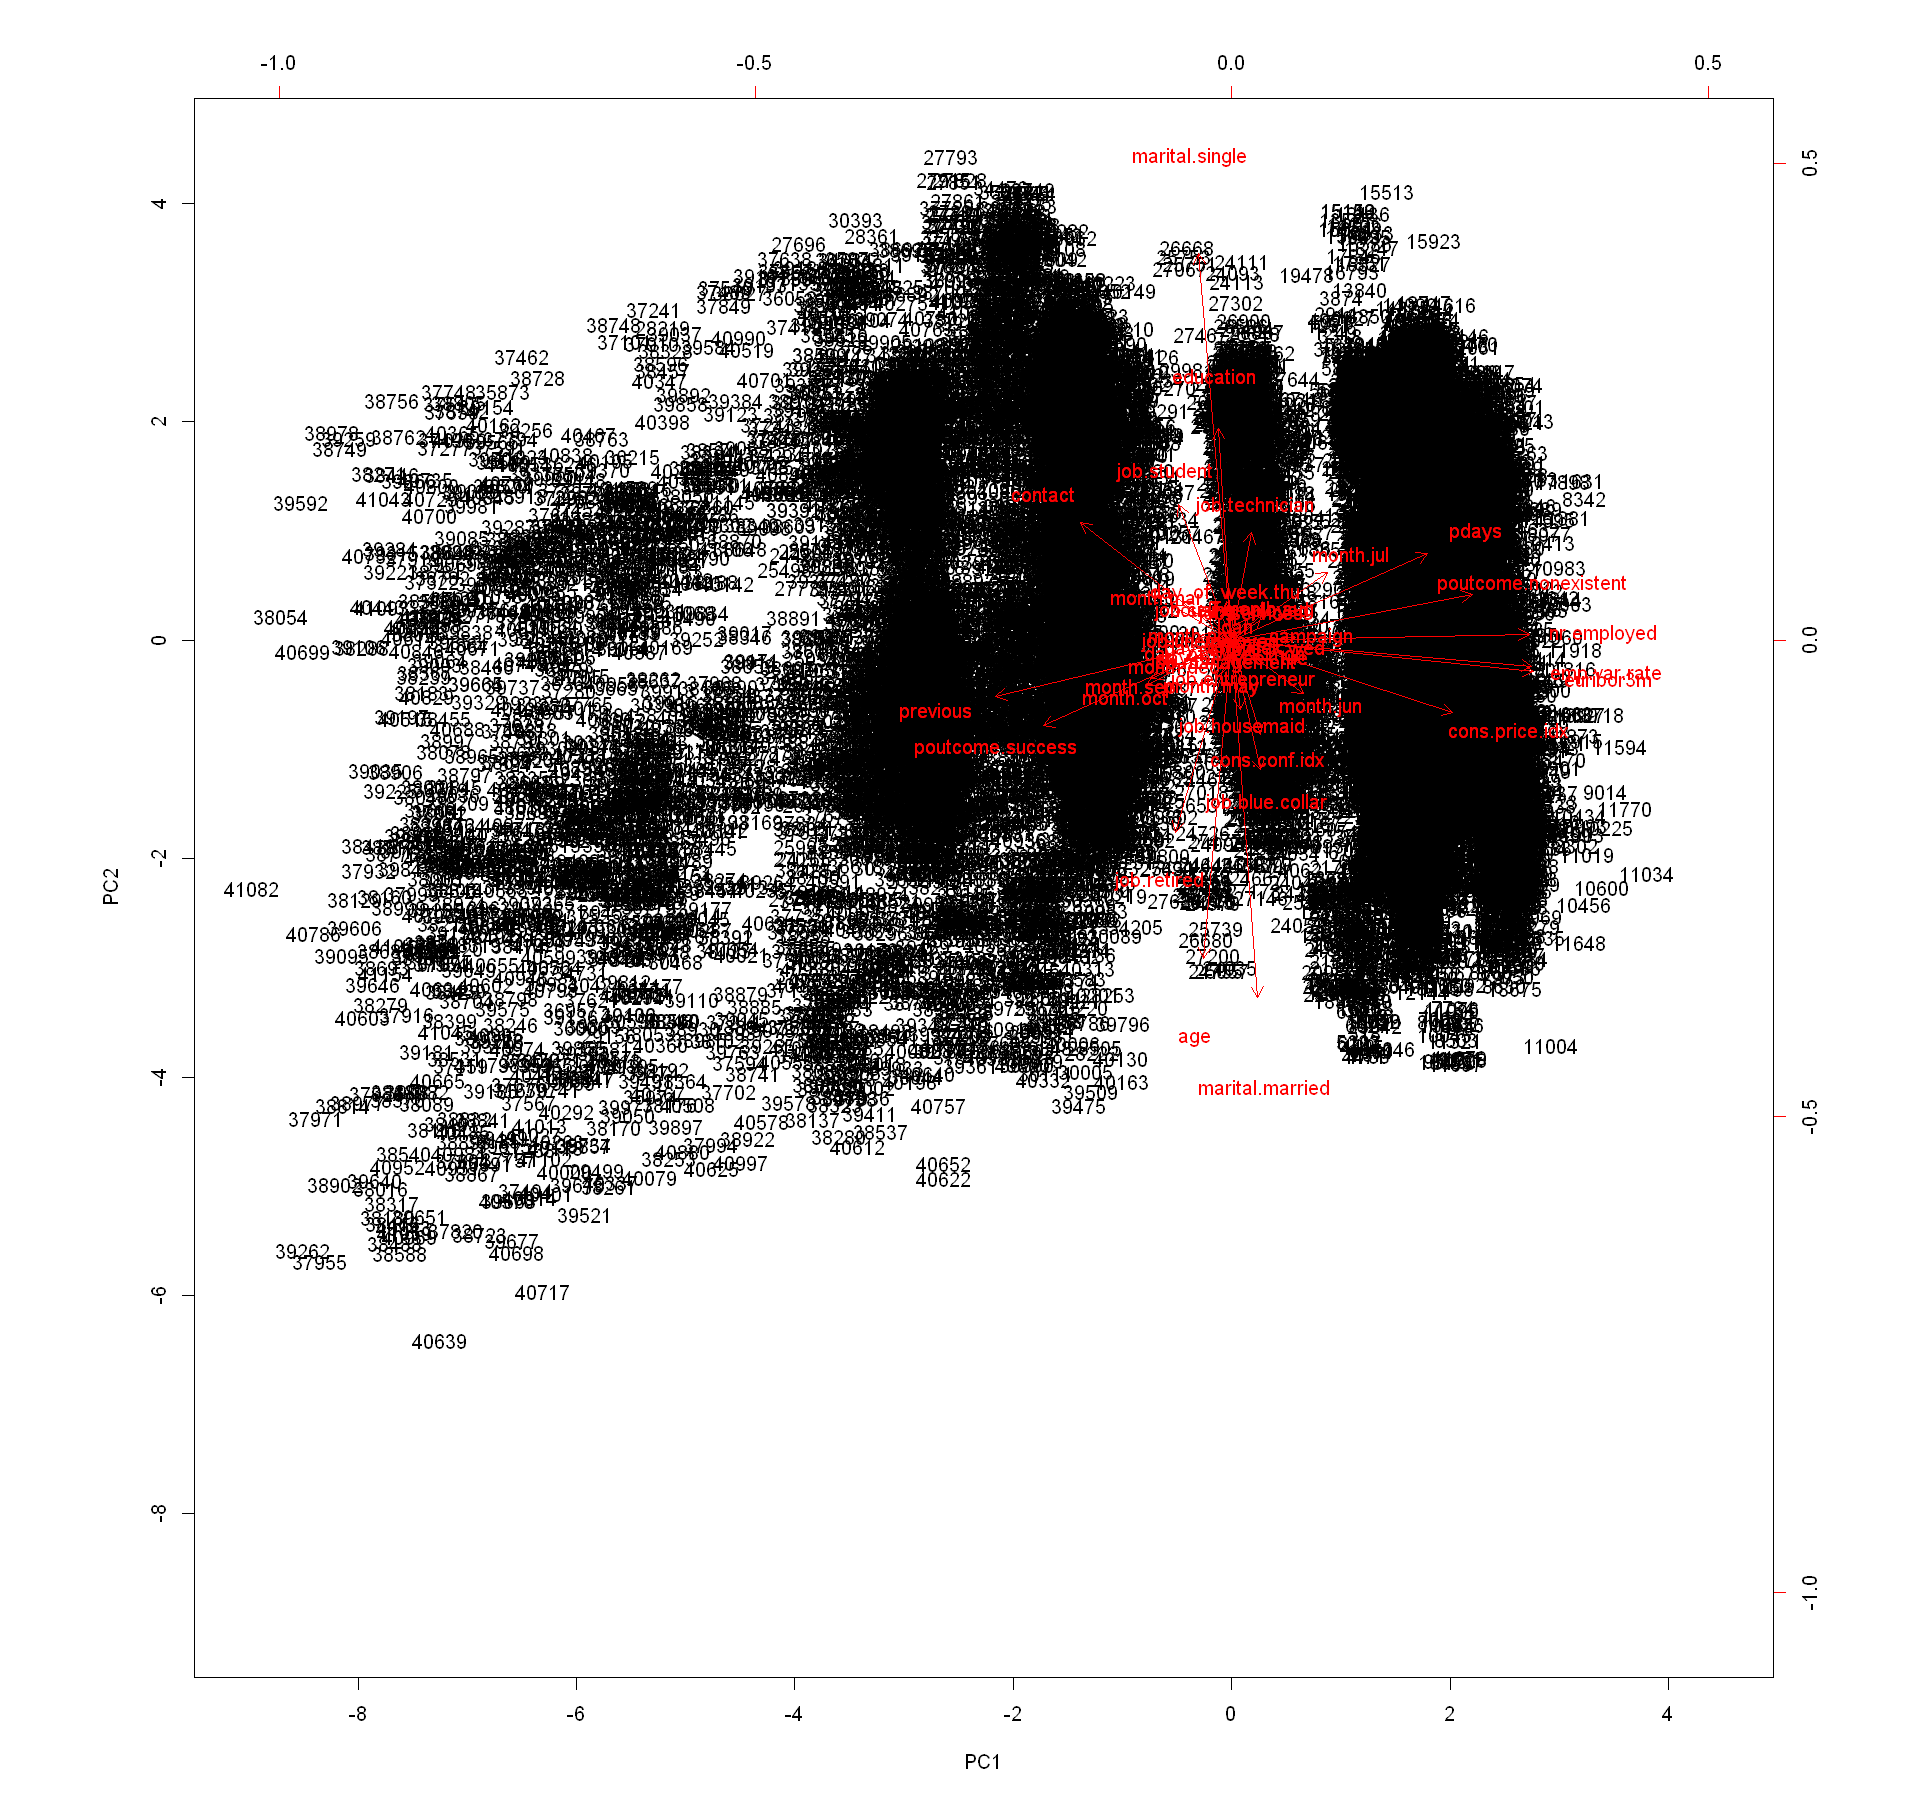

In [206]:
biplot(prin_comp,scale = 0)

### <center> The PCA image shows the significance and direction of each component </center>

In [209]:
std_dev <- prin_comp$sdev
pr_var <- std_dev^2
prop_varex <- pr_var/sum(pr_var)

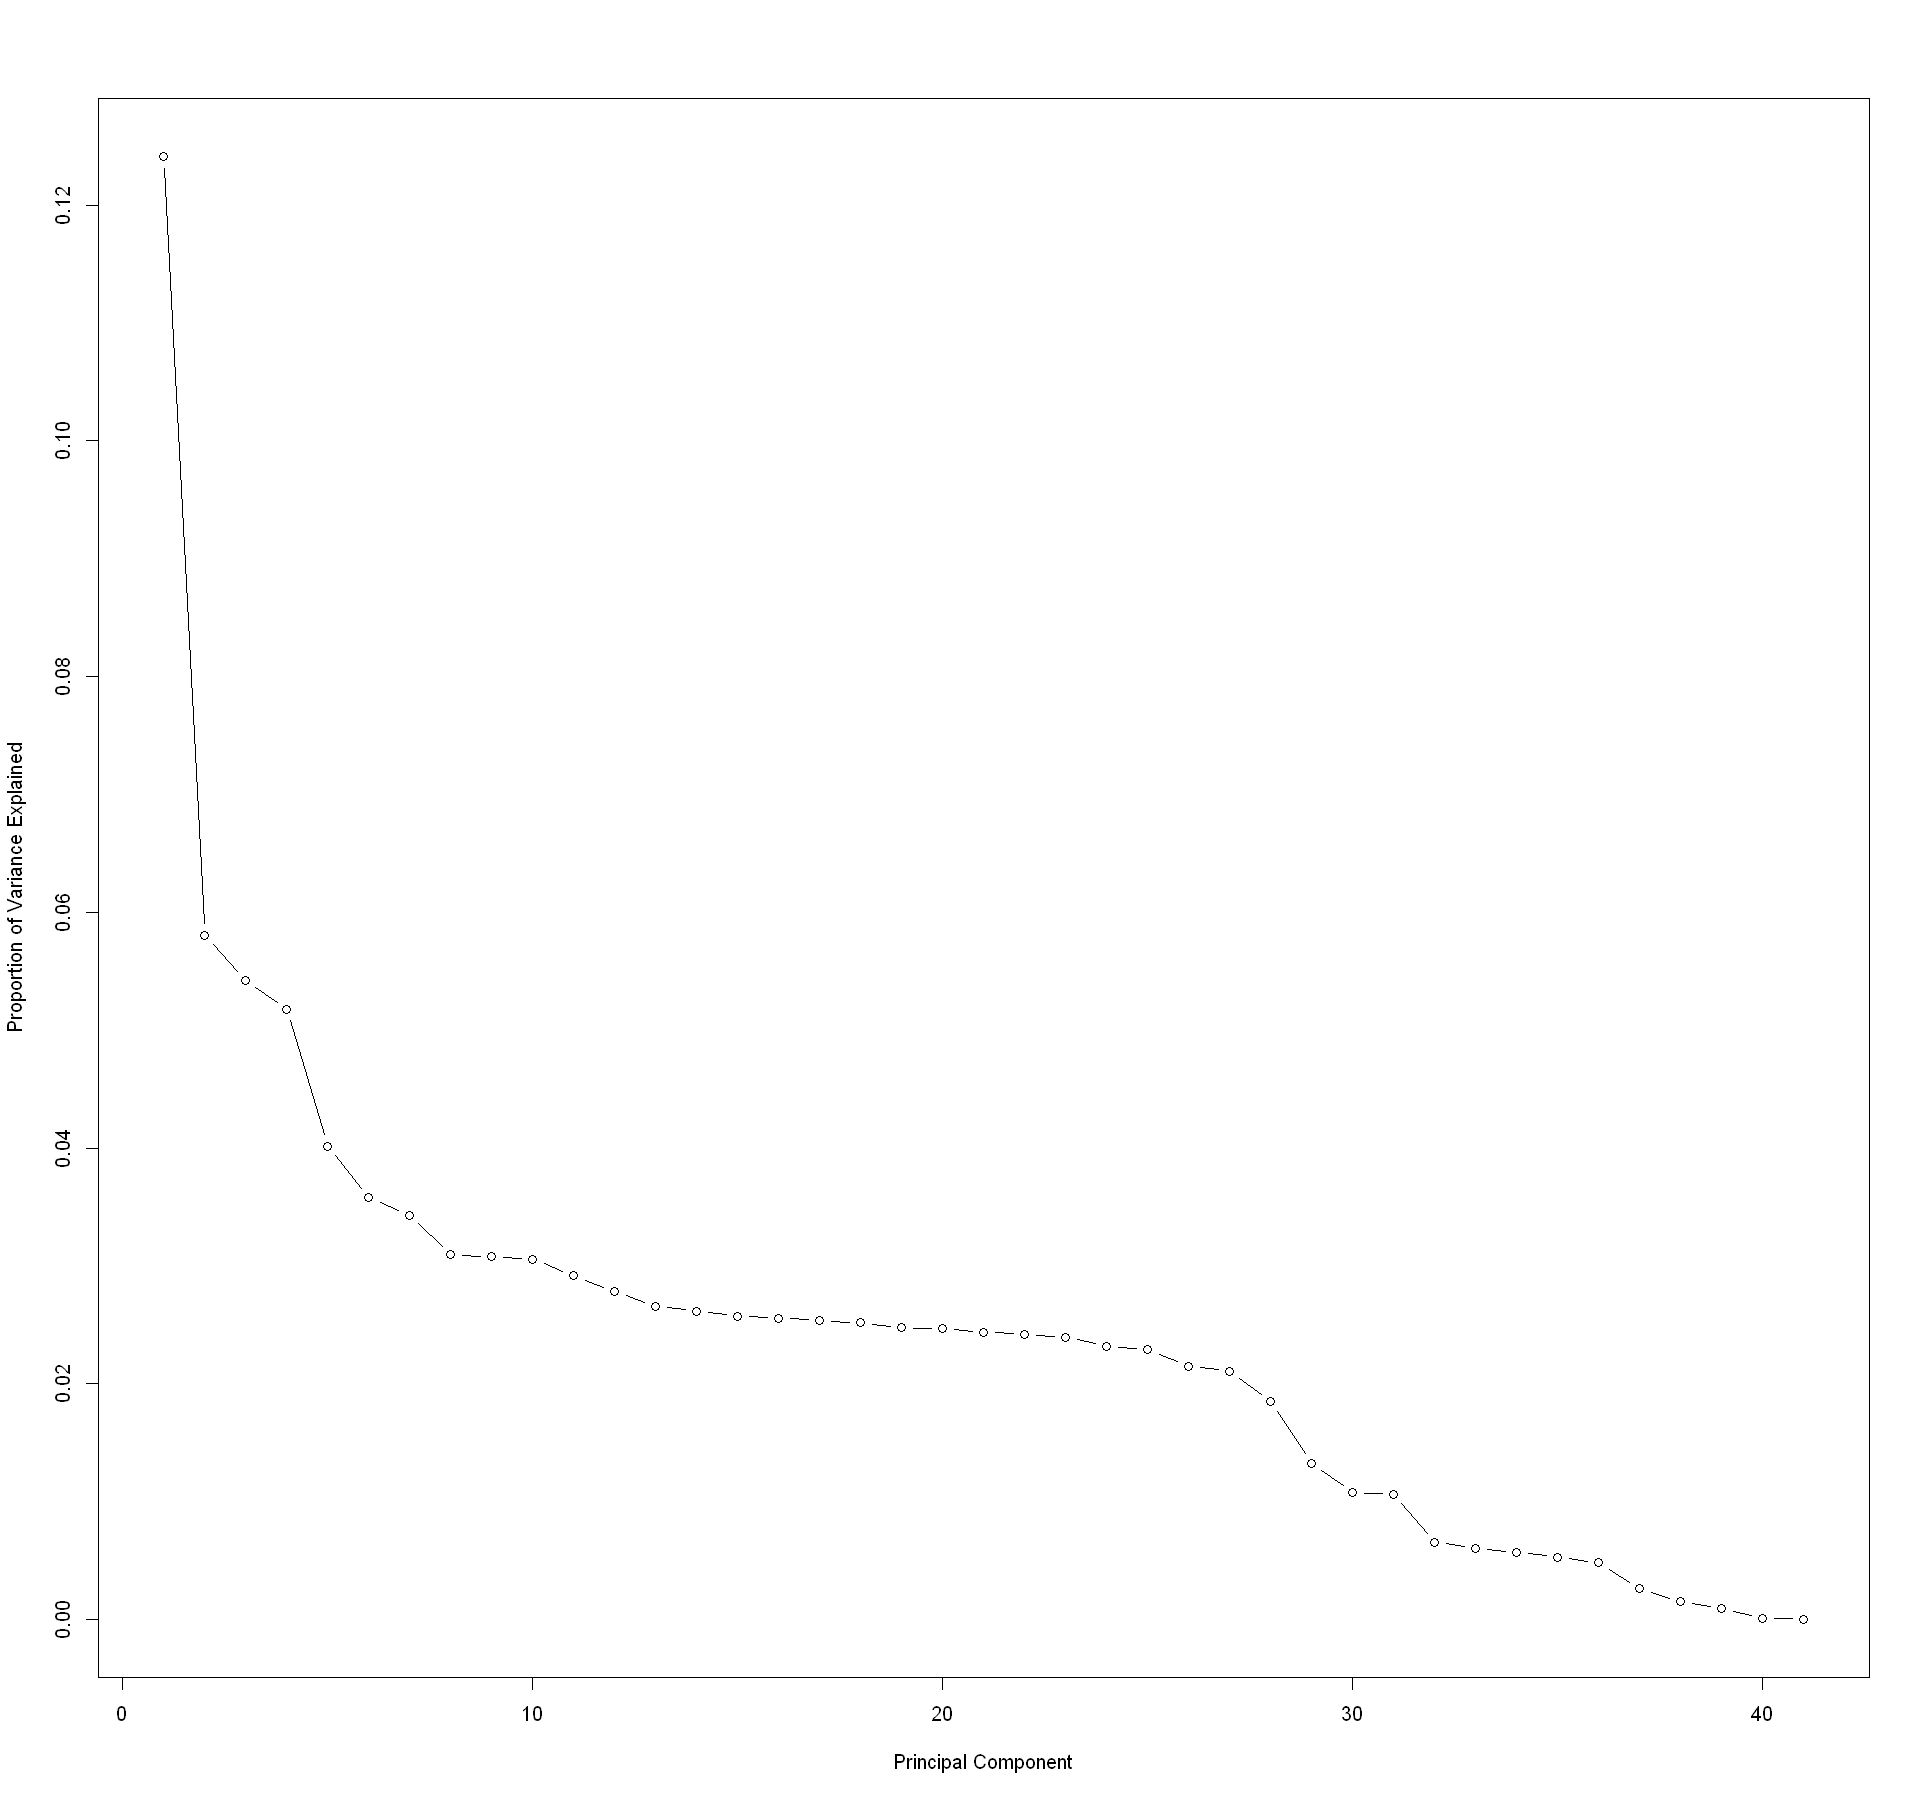

In [210]:
plot(prop_varex, xlab = "Principal Component",
             ylab = "Proportion of Variance Explained",
             type = "b")

### <center>Proportion of variance explained by each PCA</center>

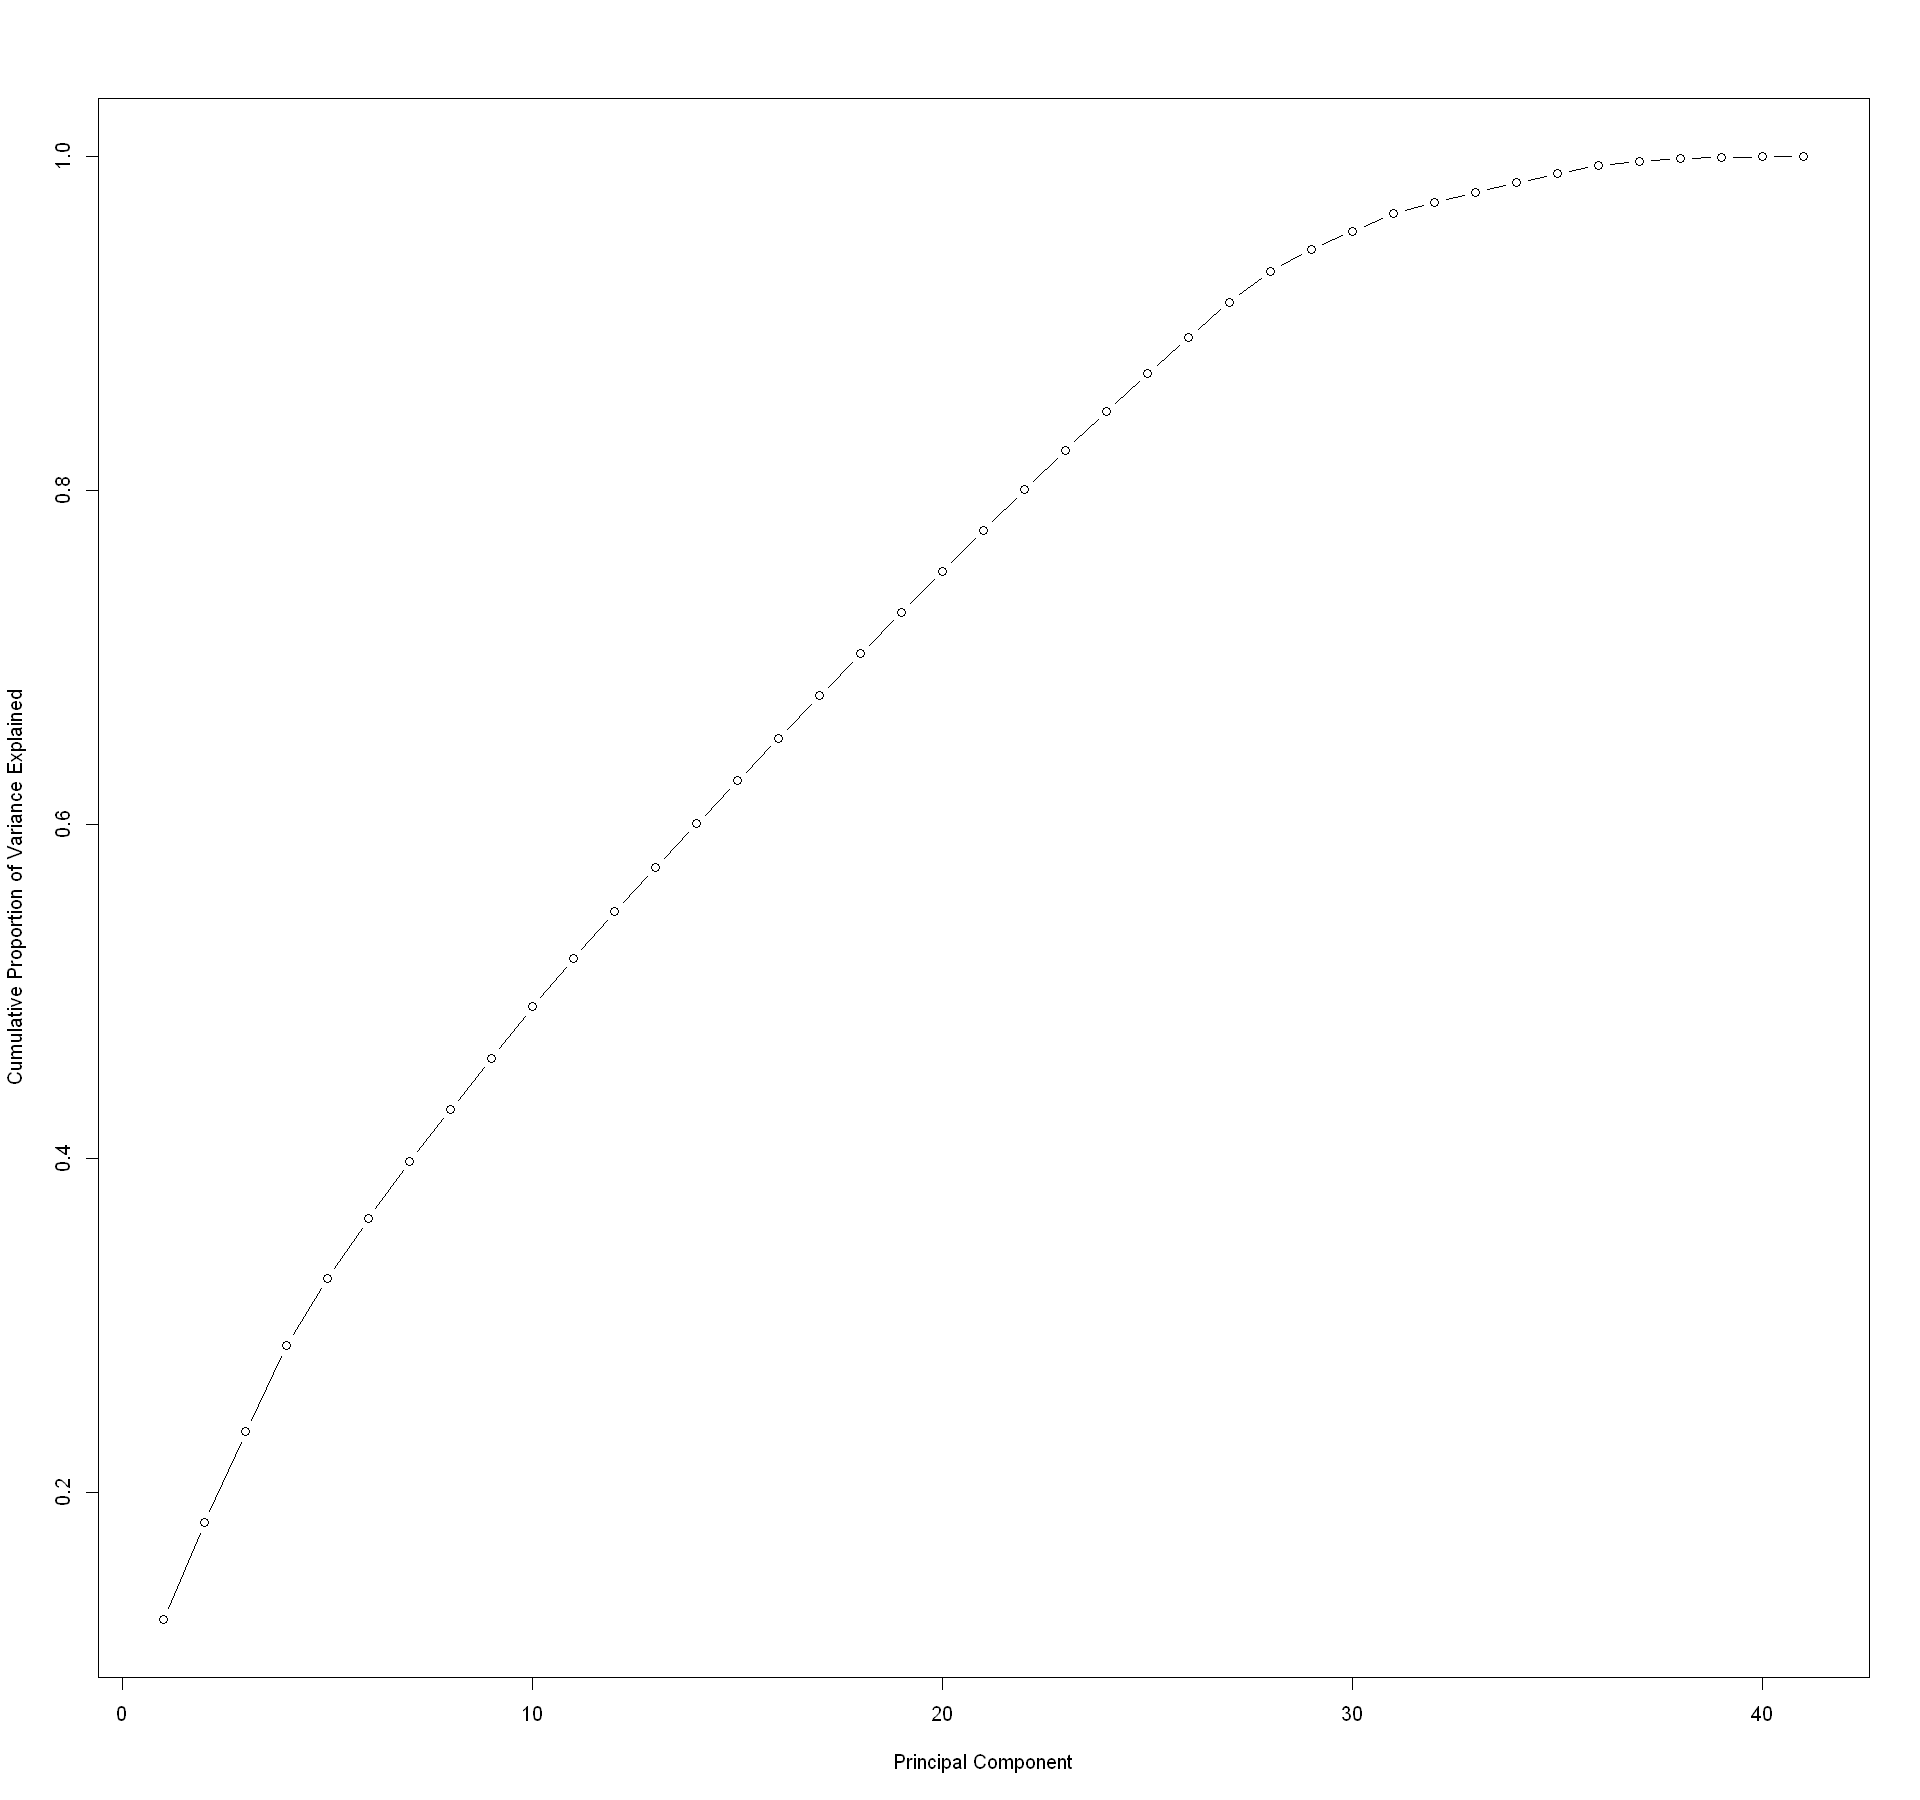

In [211]:
plot(cumsum(prop_varex), xlab = "Principal Component",
              ylab = "Cumulative Proportion of Variance Explained",
              type = "b")

### From the above picture, we can conclude that the only ~25+ components explain the data variability in 90%

# <center> K-means </center>

In [87]:
#converting to the numerical
sapply(1:42, function(i) {
  km_train[, i] <<- as.numeric(as.numeric(train_data[, i]))
})

56,1,1,2,1,1,1,1,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
37,1,1,1,1,1,1,2,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
40,1,1,1,1,1,1,1,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
56,1,1,1,1,1,1,2,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
59,1,1,1,1,1,1,1,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
24,1,1,1,1,1,1,1,1,2,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
25,1,1,1,1,1,1,2,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
25,1,1,1,1,1,1,2,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
29,2,1,1,1,1,1,1,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
57,1,1,2,1,1,1,1,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1
35,2,1,1,1,1,1,1,1,1,...,999,0,2,1,1.1,93.994,-36.4,4.857,5191,1


In [ ]:
# The k-means methods very sensitive to the scaling
normParam <- preProcess(train_data,method=c("center", "scale"))
km_train <- predict(normParam, train_data)

In [142]:
km_train<-select(km_train,-y,-pdays)

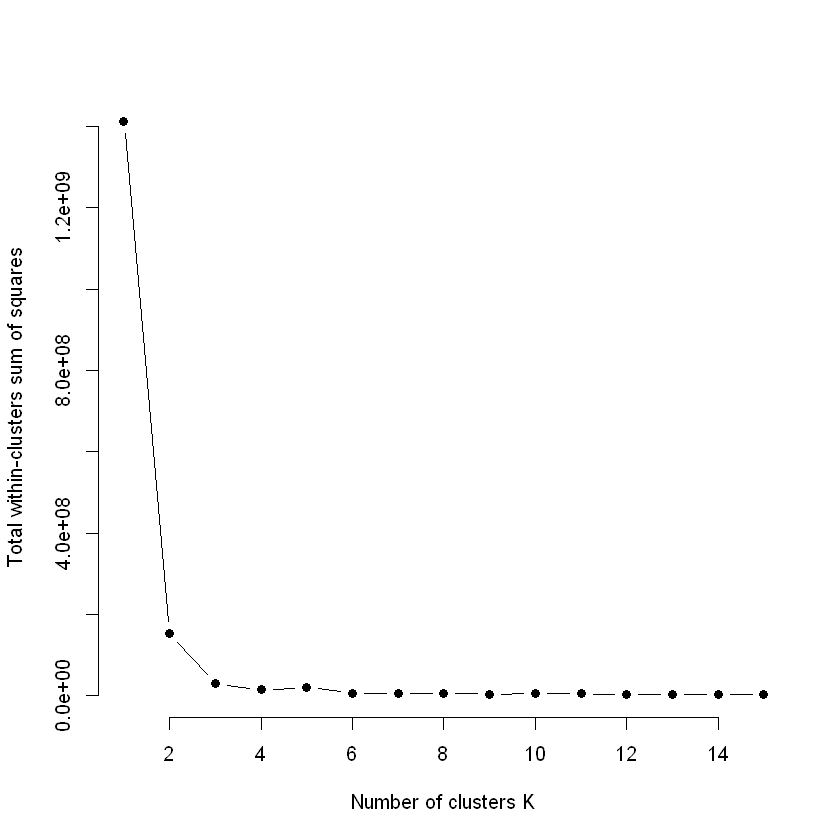

In [95]:
# function to compute total within-cluster sum of square. It shows the quality of cluster. The biiger WSS, the worth cluster. 
#It is recommended to choose the number of clusters, where WSS stops changing by a big amount.
wss <- function(k) {
  kmeans(km_train, k, nstart = 10 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:15

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

plot(k.values, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters sum of squares")

### So, according to the above comments. We should choose 2,3 clusters.

In [165]:
km.res <- kmeans(km_train, 3, nstart = 25)

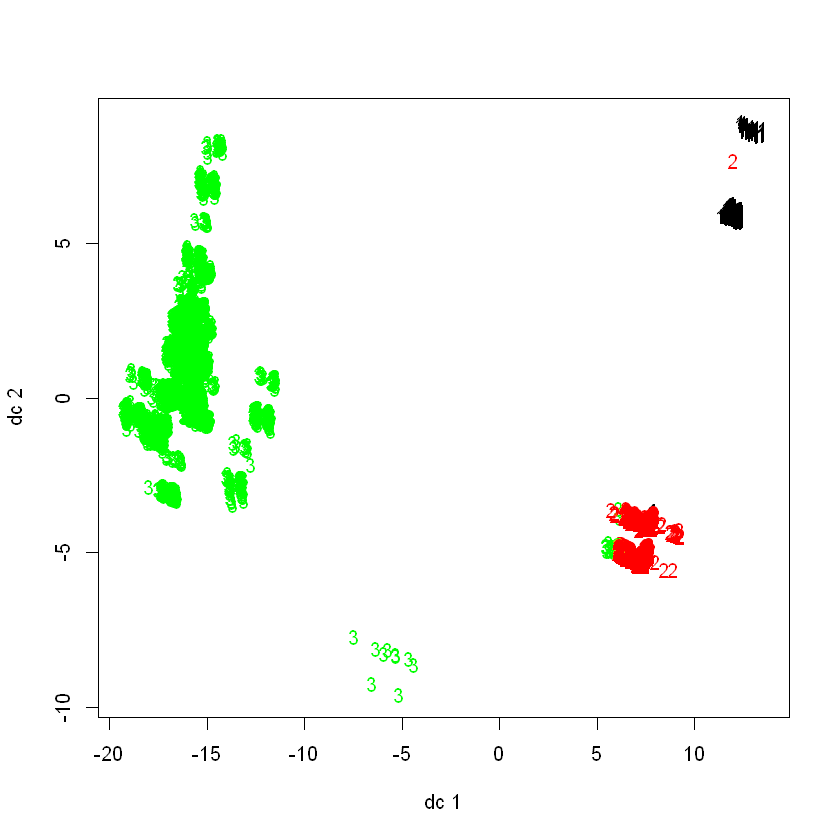

In [167]:
plotcluster(km_train, as.numeric(km.res$cluster))# clustering on km_train data

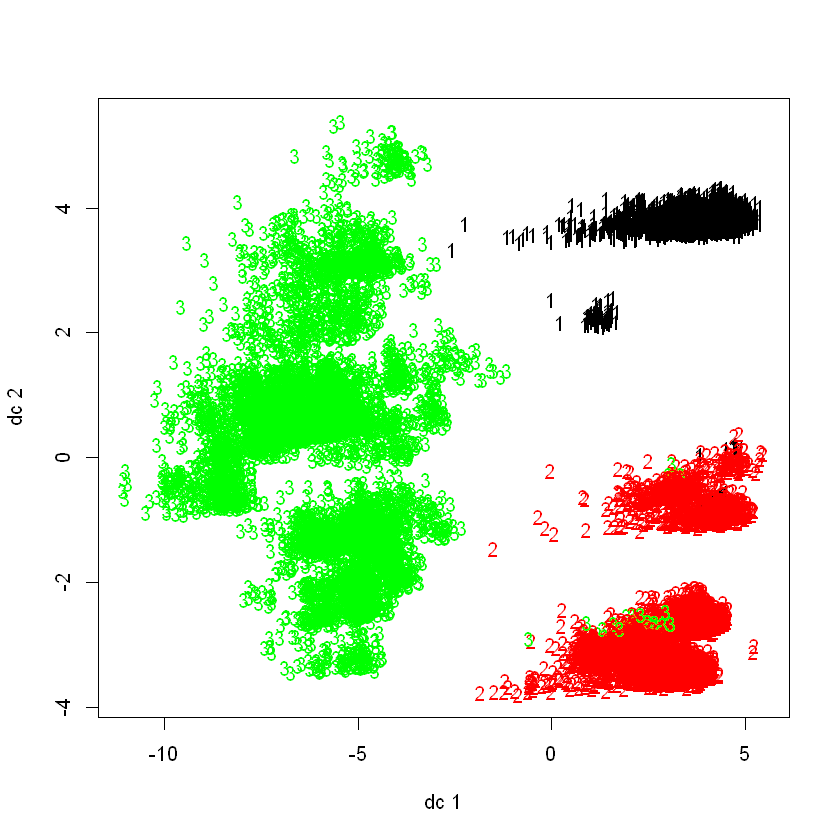

In [166]:
# clustering based on PCA
plotcluster(prin_comp$x[,1:25], as.numeric(km.res$cluster))# clustering on PCA data

# <center> Model building </center>

## logistic regression

In [85]:
folds <- 5
cvIndex <- createFolds(factor(train_data$y), folds, returnTrain = T)#for stratification purpose
tc <- trainControl(index = cvIndex,
               method = 'cv', 
               number = folds)

glmFit <- train(y ~ ., data = train_data, 
            method = "glm", 
            family = "binomial",                        
            trControl = tc,
            preProcess = c("center","scale")
            )

In [90]:
glmpred_train <- predict(glmFit,train_data,type = "raw")

In [94]:
confusionMatrix(table(glmpred_train,train_data$y)) 

Confusion Matrix and Statistics

             
glmpred_train     0     1
            0 26161  2900
            1   468   959
                                        
               Accuracy : 0.8895        
                 95% CI : (0.886, 0.893)
    No Information Rate : 0.8734        
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.3161        
                                        
 Mcnemar's Test P-Value : < 2.2e-16     
                                        
            Sensitivity : 0.9824        
            Specificity : 0.2485        
         Pos Pred Value : 0.9002        
         Neg Pred Value : 0.6720        
             Prevalence : 0.8734        
         Detection Rate : 0.8581        
   Detection Prevalence : 0.9532        
      Balanced Accuracy : 0.6155        
                                        
       'Positive' Class : 0             
                                        

In [139]:
glmpred_valid <- predict(glmFit,valid_data,type = "prob")

In [161]:
class_prediction <-
  ifelse(glmpred_valid > 0.50,
         "1",
         "0"
  )

In [167]:
actual <-valid_data$y
predicted<-class_prediction[,2]
confusionMatrix(table(actual,predicted)) 

Confusion Matrix and Statistics

   
       0    1
  0 3473   54
  1  327   98
                                         
               Accuracy : 0.9036         
                 95% CI : (0.894, 0.9126)
    No Information Rate : 0.9615         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.3            
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.9139         
            Specificity : 0.6447         
         Pos Pred Value : 0.9847         
         Neg Pred Value : 0.2306         
             Prevalence : 0.9615         
         Detection Rate : 0.8788         
   Detection Prevalence : 0.8925         
      Balanced Accuracy : 0.7793         
                                         
       'Positive' Class : 0              
                                         

In [108]:
summary(glmFit)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0687  -0.4105  -0.3290  -0.2670   2.9782  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -2.3766079  0.0263056 -90.346  < 2e-16 ***
age                   -0.0048785  0.0248476  -0.196 0.844345    
job.blue.collar1      -0.0562242  0.0307172  -1.830 0.067193 .  
job.entrepreneur1     -0.0181632  0.0222347  -0.817 0.413994    
job.housemaid1         0.0004562  0.0217126   0.021 0.983237    
job.management1       -0.0094458  0.0215386  -0.439 0.660988    
job.retired1           0.0497301  0.0210368   2.364 0.018081 *  
job.self.employed1    -0.0067980  0.0204634  -0.332 0.739736    
job.services1         -0.0424155  0.0244637  -1.734 0.082951 .  
job.student1           0.0366860  0.0158857   2.309 0.020923 *  
job.technician1        0.0034962  0.0258226   0.135 0.892300    
job.unemployed1       -0.0019337  0.0187228  -0.103 0.917740    
marital.marrie

In [ ]:
# The lower the Pr(>|z|), the more significant variable is

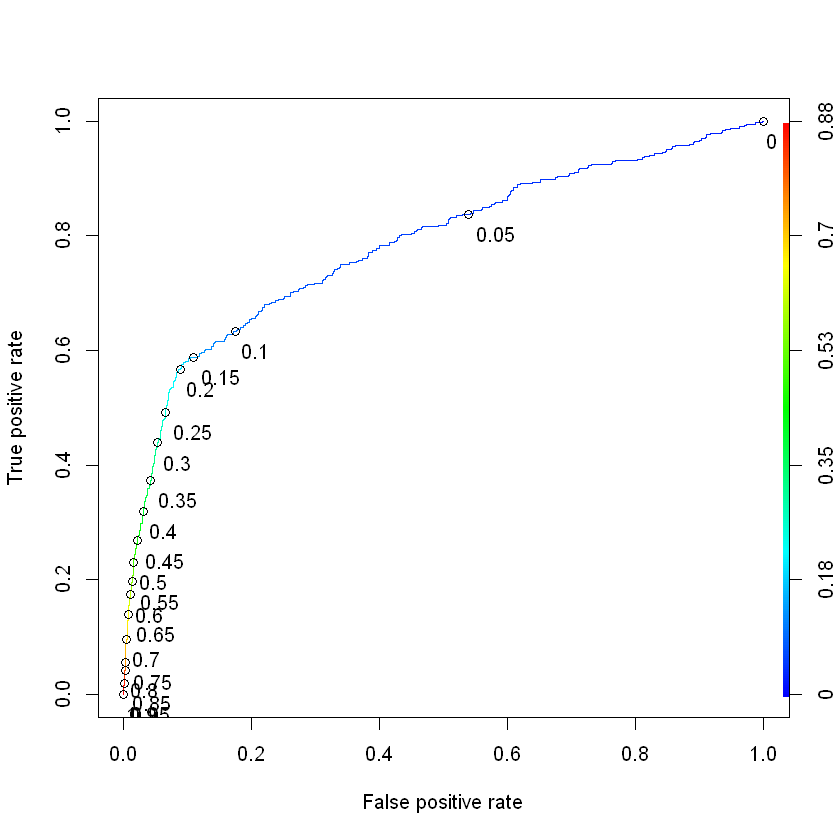

In [159]:
roc_pred <- prediction(predictions = as.numeric(glmpred_valid[,2])  , labels = as.numeric(valid_data[,"y"]))
roc_perf <- performance(roc_pred , "tpr" , "fpr")
plot(roc_perf,
     colorize = TRUE,
     print.cutoffs.at= seq(0,1,0.05),
     text.adj=c(-0.2,1.7))

## Random forest

In [ ]:
control <- trainControl(method="repeatedcv", number=5, repeats=3, search="grid")
set.seed(7)
metric <- "Accuracy"
mtry <- sqrt(ncol(train_data))
tunegrid <- expand.grid(.mtry=mtry)
tunegrid <- expand.grid(.mtry=c(1:20))
rf_gridsearch <- train(y~., data=train_data, method="rf", metric=metric, tuneGrid=tunegrid, trControl=control)
print(rf_gridsearch)
plot(rf_gridsearch)

### SVM

In [29]:
#Grid search to fine tune SVM
grid <- expand.grid(sigma = c(.01, .015, 0.2),
                    C = c(0.75, 0.9, 1, 1.1, 1.25)
)

In [ ]:
folds <- 3
cvIndex <- createFolds(factor(train_data$y), folds, returnTrain = T)#for stratification purpose
tc <- trainControl(index = cvIndex,
               method = 'cv', 
               number = folds,
               summaryFunction=twoClassSummary,
                        )

cvFit <- train(y ~ ., data = train_data, 
            method = "svmRadial",                         
            trControl = tc,
            tuneGrid = grid,   
            preProcess = c("center","scale")
            )

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

In [24]:
cv_pred <- predict(cvFit, valid_data,type = "prob")

In [ ]:
class_prediction <-
  ifelse(cv_pred > 0.50,
         "1",
         "0"
  )


In [ ]:
confusionMatrix(table(valid_data[,"y"],class_prediction[,2])) 

In [ ]:
# Plot the ROC curve

roc_pred <- prediction(predictions = as.numeric(cv_pred[,2])  , labels = as.numeric(valid_data[,"y"]))
roc_perf <- performance(roc_pred , "tpr" , "fpr")
plot(roc_perf,
     colorize = TRUE,
     print.cutoffs.at= seq(0,1,0.05),
     text.adj=c(-0.2,1.7))